**permutation**：置换重要性,就是把某个特征在验证集里“打乱顺序”，再看模型分数掉了多少；掉得越多，说明该特征对预测越重要。

## 原理
- 给定已训练好的模型 f 和验证集 $X_val, y_val$。
- 先算**基线分数**
 $$
 S_0 = \text{score}(y_{\text{val}}, f(X_{\text{val}}))
 $$
 （分数可用R^2,-MSE,-MAE）。
- 对第j个特征：把X_val的第j列随机打乱，重算分数  
  $$
  S_j = \text{score}(y_{\text{val}}, f(X_{\text{val}}^{(j)}))
  $$。
- 定义重要性  
$$
  I_j = S_0 - S_j
$$
  若用的是**损失**（MAE/MSE）做分数，就把式子换成  
$$
  I_j = \text{loss}\big(f(X_{\text{val}}^{(j)})\big) - \text{loss}\big(f(X_{\text{val}})\big)
$$
  ——损失涨多少就是重要性。
- 为了降低随机波动，**重复置换 $R$ 次**，取均值/标准差：  
$$
\bar I_j=\frac{1}{R}\sum_{r=1}^R I_{j,r}
$$。

## permutation衡量的是
在**固定模型**下，特征 $x_j$ 与目标 $y$ 的 **条件关联（given 其它特征）** 对最终预测分数的贡献。直观地说：把这列破坏掉后，模型还能靠其他列“兜底”多少。


## 优势与局限
- **优势**：与模型无关、样本外衡量、可直接对接业务指标（IC、收益、MAE…）。
- **局限**：相关特征会**低估**单列重要性；计算量 ≈ 特征数 × 重复次数 × 一次推理成本。需要用成组置换/聚类来缓解。

## 多重共线性对 permutation_importance 的影响

本节讨论在 **特征高度相关（多重共线性）** 的情况下，`permutation_importance` 度量特征重要性时会出现的偏差与局限。

---

### 一、permutation importance 在做什么？

给定一个已经训练好的模型，`permutation_importance` 的基本步骤是：

1. 用验证集（或测试集）计算模型的**基准性能**（如 MSE、R²）。
2. 选定某一列特征 $X_j$，将这列在验证集中**随机打乱顺序**，打乱后：
   - 边际分布不变；
   - 但 $X_j$ 与目标值 $y$ 的对应关系被破坏。
3. 用同一个模型在“打乱后的数据”上重新预测，计算新的性能。
4. **新性能相比基准性能的下降幅度**，视为特征 $X_j$ 的 permutation importance。

直观理解：  
> “如果仅破坏这一列特征的有效信息，模型性能会掉多少？”

---

### 二、什么是多重共线性？

多重共线性指的是：**一组特征之间高度相关，甚至近似线性组合**。  
例如：

- $$
  X_2 \approx X_1 
  $$
- $$
  X_3 \approx 0.9 X_1 + 0.1 X_4 + \varepsilon
$$

在这种情况下，**预测所需的信息被多列特征“共享”**，而不是集中在某一列上。

---

### 三、多重共线性带来的典型影响

#### 1. 重要性被“稀释”：单个特征看起来不重要

极端例子：

- 真正驱动 $y$ 的只有一个潜在因子 $Z$；
- 你构造了两列高度相关的特征：$X_1 = Z$、$X_2 = Z$。

模型在训练时会同时使用 $X_1$ 和 $X_2$ 中的信息。

当对 $X_1$ 做 permutation 时：

- $X_1$ 的信息被破坏；
- 但 **$X_2$ 仍然保留了几乎全部关于 $Z$ 的信息**；
- 因此模型性能下降不多，permutation importance 对 $X_1$ 的评分就很低。

同理，对 $X_2$ 做 permutation 时，$X_1$ 也在兜底。

结果是：

- “这两个特征整体非常重要”，但
- **每个单独特征的 permutation importance 都被严重低估**。

> 结论：在强共线下，permutation importance 测的是“在有一堆替身时，少一个替身会多痛”，自然不痛太多。

---

#### 2. 排名不稳定：重要性结果对随机性敏感

共线特征之间的信息高度重叠，模型对它们的“依赖分配”常常不唯一：

- 线性模型中，共线特征的回归系数可以在它们之间来回“搬家”；
- 树模型 / GBDT 中，split 时也可能在多列相关特征中随机选一列来切分。

再叠加 permutation 本身的随机打乱，结果是：

- 在不同 random seed、不同交叉验证折中，**同一特征的重要性波动很大**；
- 同一组高度相关特征中，**“谁排第一、谁排倒数”很大程度由训练偶然性决定**。

表现为：

- 条形图误差条很宽；
- 折间平均的重要性排序不稳定。

---

#### 3. 噪声特征被“抬高”或与真实特征混淆

如果某些特征本质上只是其他特征的“噪声版本”或滞后变换，例如：

- $X_5 = X_1 + \text{小噪声}$
- 或者多个高相关但经济意义不同的变种指标

在多重共线下可能出现：

- 模型有时更依赖 $X_1$，有时更依赖 $X_5$；
- 做 permutation 时，**打乱任意一个，只要其他相关特征还在，性能就不会掉太多**；
- 于是几列相关特征都拿到类似的重要性评分，哪怕其中一些几乎是“伪信号”。

> 结果：真实信号与派生噪声在 importance 上被混在一起，很难只凭 permutation importance 做干净识别。



## 一个简单例子

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import os
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn as sk
import lightgbm
# =============================
# 1) 生成“强多重共线性”的玩具数据
# =============================

def make_multicollinear_regression_data(n_samples=30000, random_state=0):
    rng = np.random.RandomState(random_state)
    
    # 潜在真正信号 z1, z2
    z1 = rng.normal(loc=0.0, scale=1.0, size=n_samples)
    z2 = rng.normal(loc=0.0, scale=1.0, size=n_samples)
    z3 = rng.normal(loc=0.0, scale=1.0, size=n_samples)
    
    # 真正起作用的特征
    x1_signal = z1
    x2_signal = z2
    x3_signal = z3
    
    # 强共线“克隆”特征（几乎就是复制，多一点点噪声）
    x1_clone = x1_signal + rng.normal(scale=0.02, size=n_samples)  # 和 x1_signal 相关系数 ≈ 0.99+
    x_clone = -0.9*x1_signal + 0.1*x3_signal + rng.normal(scale=0.02, size=n_samples)  # 和 x3_signal 相关系数 ≈ 0.99+
    
    # 完全无关的噪声特征
    x4_noise = rng.normal(loc=0.0, scale=1.0, size=n_samples)
    
    # 构造目标 y：只依赖 x1_signal 和 x3_signal
    # y = 3 * x1 + 2 * x3 + 噪声
    y = 3.0 * x1_signal*x1_signal + 2.0 * x3_signal + 1.5 * x1_signal*x2_signal + 0.5*x2_signal  + rng.normal(scale=0.5, size=n_samples)
    # * x3_signal + 1.5 * x1_signal*x3_signal
    X = pd.DataFrame({
        "x1_signal": x1_signal,
        "x1_clone":  x1_clone,
        "x3_signal": x3_signal,
        "x2_signal":  x2_signal,
        "x_clone":   x_clone,
        "x4_noise":  x4_noise,
    })
    
    y = pd.Series(y, name="y")
    return X, y


# =============================
# 2) 构建 LightGBM 模型
# =============================

def make_lgbm_regressor(random_state=42):
    model = LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        verbose = -1,
        n_jobs=-1
    )
    return model
# =============================
# 3) 简易的permutation框架
# =============================
def permutation_easy(
        X_train, 
        y_train,
        estimator,
        n_splits=5,
        n_repeats=1,
        random_state=42,
        top_n_features=10
    ):

    # ----------------------------------------------
    # 1) K 折 permutation importance 计算
    # ----------------------------------------------
    feature_importance_permuation_list = []
    feature_importance_permuation_std_list = []
    splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train, y_train)
    for fold, (train_idx, val_idx) in enumerate(splitter):
        model = sk.base.clone(estimator)
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold   = X_train.iloc[val_idx]
        y_val_fold   = y_train.iloc[val_idx]
        model.fit(X_train_fold, y_train_fold)
        result = permutation_importance(
            model,
            X_val_fold,
            y_val_fold,
            scoring='neg_mean_absolute_error',
            n_repeats=n_repeats,
            random_state=random_state
        )
        imp_mean = pd.Series(result.importances_mean, index=X_train.columns)
        imp_std  = pd.Series(result.importances_std, index=X_train.columns)
        feature_importance_permuation_list.append(imp_mean)
        feature_importance_permuation_std_list.append(imp_std)
    # ----------------------------------------------
    # 2) 汇总重要性 & 稳定性指标
    # ----------------------------------------------
    permutation_importance_by_fold = pd.concat(feature_importance_permuation_list, axis=1)
    permutation_importance_by_fold.columns = [f'fold_{i}' for i in range(n_splits)]
    permutation_importance_std_by_fold = pd.concat(feature_importance_permuation_std_list, axis=1)
    permutation_importance_std_by_fold.columns = [f'fold_{i}_std' for i in range(n_splits)]
    permutation_importance_mean = permutation_importance_by_fold.mean(axis=1)
    permutation_importance_by_fold['avg_fold'] = permutation_importance_mean

    return permutation_importance_by_fold


# =============================
# 3) 示例：调用你的 permutation 框架
# =============================

# 生成数据
X_example, y_example = make_multicollinear_regression_data(
    n_samples=30000,
    random_state=0
)

# LightGBM 模型
estimator_example = make_lgbm_regressor(random_state=42)


## 数据生成部分的逻辑概括（`make_multicollinear_regression_data`）

这段代码的目的：**构造一个带有强多重共线性的回归玩具数据集**，方便用来测试 LightGBM + permutation importance 在共线场景下的表现。

### 1. 随机生成潜在“真实信号”

- 使用正态分布生成三个独立的潜在变量：
  - `z1 ~ N(0, 1)`
  - `z2 ~ N(0, 1)`
  - `z3 ~ N(0, 1)`

并设定为真正有效的基础信号：

- `x1_signal = z1`
- `x2_signal = z2`
- `x3_signal = z3`

### 2. 构造强共线特征（克隆特征）

- 第一个克隆特征：
  - `x1_clone = x1_signal + 很小的高斯噪声（σ = 0.02）`
  - 与 `x1_signal` 的相关系数 ≈ 0.99+，形成一对高度共线特征。

- 第二个“线性组合型”共线特征：
  - `x_clone = -0.9 * x1_signal + 0.1 * x3_signal + 很小的噪声`
  - 与 `x1_signal`、`x3_signal` 都存在较强线性关系，是另一种形式的共线结构。

### 3. 构造无关噪声特征

- `x4_noise` 完全独立于 `z1, z2, z3`，且与目标 `y` 理论上无关：
  - `x4_noise ~ N(0, 1)`

### 4. 构造非线性 + 交互项的目标变量 `y`

目标 `y` 只由真实信号（不是噪声特征）决定，并刻意加入非线性和交互：

$$
y = 3 \cdot x1\_signal^2
  + 1.5 \cdot x1\_signal \cdot x2\_signal 
  + 2 \cdot x3\_signal 
  + 0.5 \cdot x2\_signal
  + \epsilon
$$

其中：

- 噪声项 `ε ~ N(0, 0.5^2)`；
- `x4_noise` **不参与**任何形式的 y 生成。

### 5. 打包为 DataFrame / Series 返回

- 将所有特征打包成一个 `pandas.DataFrame X`，列包括：
  - `"x1_signal"`, `"x1_clone"`, `"x3_signal"`, `"x2_signal"`, `"x_clone"`, `"x4_noise"`
- 将目标打包成 `pandas.Series y`，名字为 `"y"`。
- 返回 `(X, y)`。

这一套设计让你在后续 permutation importance 中可以清楚地观察：

- 真正驱动 y 的信号（`x1_signal, x2_signal, x3_signal`）；
- 它们的共线“影子”（`x1_clone, x_clone`）如何稀释单个特征的 permutation 重要性；
- 完全无关的噪声特征 `x4_noise` 应该得到接近 0 的 importance。


In [105]:
importance_raw = permutation_easy(
    X_train=X_example,
    y_train=y_example,
    estimator=estimator_example,
    n_splits=5,
    n_repeats=10,
    random_state=42,
    top_n_features=5
)

X_example_cleaned = X_example.drop(columns=['x_clone'])
importance_drop1 = permutation_easy(
    X_train=X_example_cleaned,
    y_train=y_example,
    estimator=estimator_example,
    n_splits=5,
    n_repeats=10,
    random_state=42,
    top_n_features=5
)
X_example_cleaned = X_example.drop(columns=['x1_clone'])
importance_drop2 = permutation_easy(
    X_train=X_example_cleaned,
    y_train=y_example,
    estimator=estimator_example,
    n_splits=5,
    n_repeats=10,
    random_state=42,
    top_n_features=5
)
X_example_cleaned = X_example.drop(columns=['x1_signal'])
importance_drop3 = permutation_easy(
    X_train=X_example_cleaned,
    y_train=y_example,
    estimator=estimator_example,
    n_splits=5,
    n_repeats=10,
    random_state=42,
    top_n_features=5
)
X_example_cleaned = X_example.drop(columns=['x_clone','x1_clone'])
importance_drop4 = permutation_easy(
    X_train=X_example_cleaned,
    y_train=y_example,
    estimator=estimator_example,
    n_splits=5,
    n_repeats=10,
    random_state=42,
    top_n_features=5
)


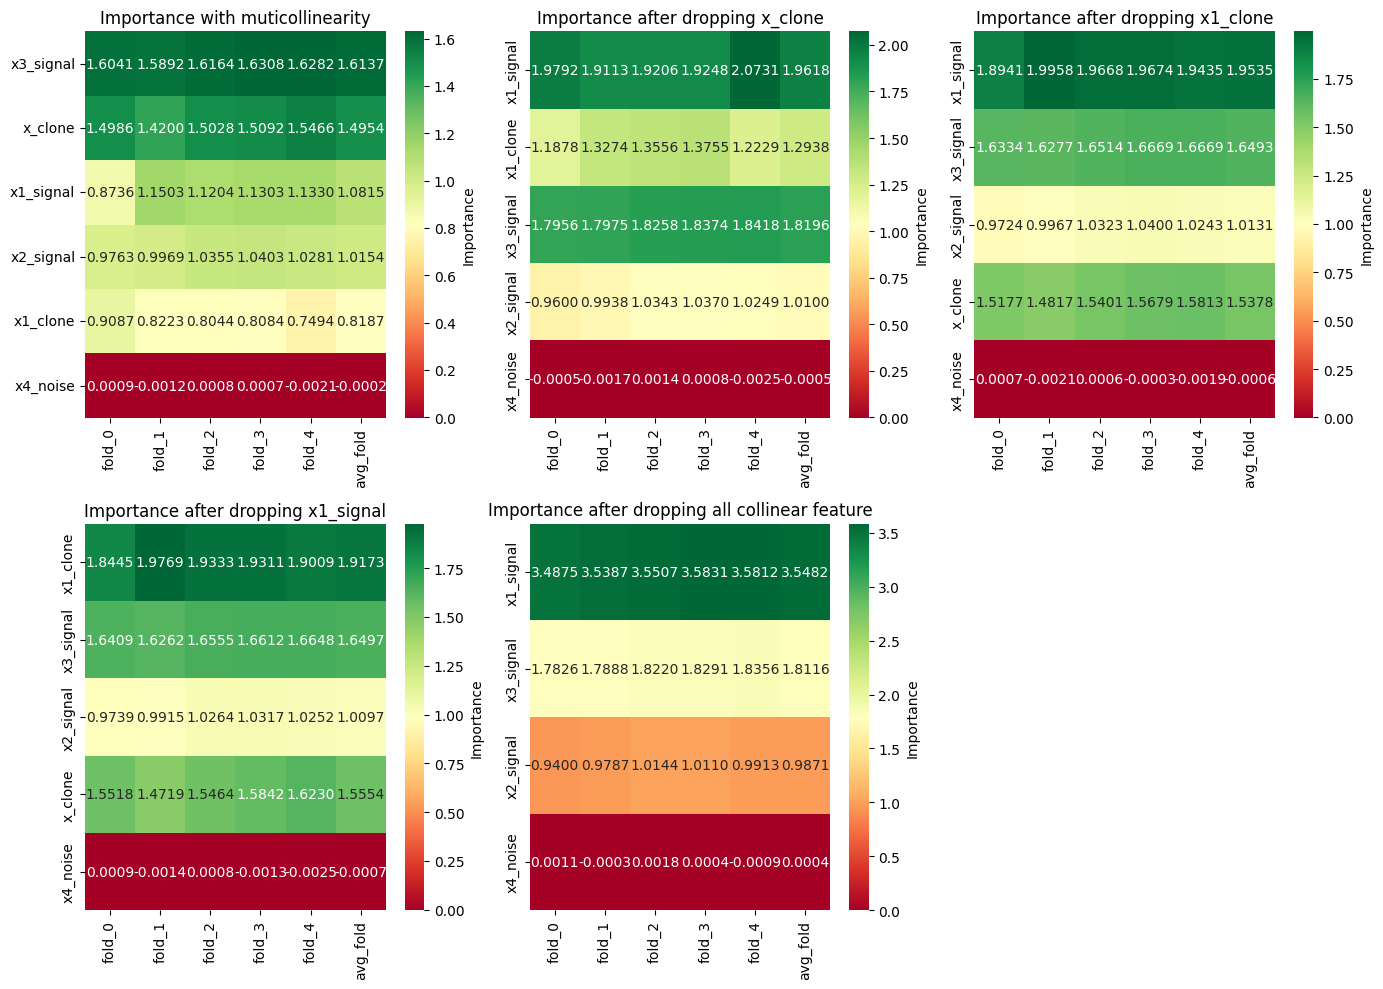

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

# 将数据转换为适合热力图的二维格式
sns.heatmap(importance_raw.sort_values('avg_fold', ascending=False),
                annot=True, fmt='.4f', cmap='RdYlGn', cbar_kws={'label': 'Importance'},ax=axes[0][0])
axes[0][0].set_title("Importance with muticollinearity")
axes[0][0].set_ylabel('')  # 隐藏y轴标签

sns.heatmap(importance_drop1, 
            annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Importance'}, 
            ax=axes[0][1])
axes[0][1].set_title("Importance after dropping x_clone")
axes[0][1].set_ylabel('')

sns.heatmap(importance_drop2, 
            annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Importance'}, 
            ax=axes[0][2])
axes[0][2].set_title("Importance after dropping x1_clone")
axes[0][2].set_ylabel('')

sns.heatmap(importance_drop3, 
            annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Importance'}, 
            ax=axes[1][0])
axes[1][0].set_title("Importance after dropping x1_signal")
axes[1][0].set_ylabel('')

sns.heatmap(importance_drop4, 
            annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Importance'}, 
            ax=axes[1][1])
axes[1][1].set_title("Importance after dropping all collinear feature")
axes[1][1].set_ylabel('')
axes[1][2].axis('off')  # 这会隐藏该子图的所有坐标轴元素
plt.tight_layout()
plt.show()

### 6. 模拟结果
可以清楚地观察到：

- 真正驱动 y 的信号（`x1_signal, x2_signal, x3_signal`）表现出来较好的重要性，噪声`x4_signal`的重要性始终接近0。
- 信号的共线“影子”（`x1_clone, x_clone`）会稀释单个特征的 permutation 重要性 (`x_clone`降低了`x1_signal,x3_signal`的重要性；`x1_clone`降低了`x1_signal`的重要性)
- 即使删去真正驱动y的信号 `x1_signal`，相似的特征`x1_clone,x_clone`也能顶上。

### 四、结合实际现象怎么读图？

在存在多重共线性时，你可能在 permutation importance 可视化中看到以下现象：

- 明显“有经济意义”的核心特征被排在中游甚至靠后；
- 同一类特征（如同一因子的不同滞后、不同构造方式）重要性分数挤成一团；
- 不同折、不同子样本中的排名差异很大；
- 一些看起来像“衍生噪声”的特征重要性意外地不低。

这些现象往往不是模型“认不出信号”，而是 **指标定义本身在共线结构下已经失真**。

---

### 五、如何缓解（方向性建议）

在多重共线性显著时，可以考虑：

- **成组 / 成簇打乱**：  
  先用相关矩阵或聚类，将高度相关的特征划成若干组，再用 permutation importance 按“组”打乱，评估每组整体的重要性。
- **先做去冗余特征选择**：  
  利用方差过滤 + 相关性截断（VT + CorrClip）、PCA 或因子模型等，先消除一部分共线，再做 permutation importance。
- **调整预期**：  
  在强共线情形下，**不要把 permutation importance 解读成“精确经济意义排名”**，更多当作：  
  - 粗筛掉完全没用或极弱的特征；
  - 辅助识别“哪个因子家族整体比较重要”。

---

### 六、总结

在多重共线性显著的数据上：

- permutation importance **低估单个相关特征的边际重要性**；
- **放大结果的随机性和不稳定性**；
- 难以在高度相关的一组特征中给出清晰、可信的“谁更重要”的排序。

一句话概括：

> 在有一堆“信息替身”的情况下，permutation importance 更像是在测“少一个替身会多难受”，而不是在测“这个人本身有多重要”。


## 回到原本的Factors数据

下面使用两种方法简单测试一下多重共线性影响对permutation结果的影响。

In [152]:
SEED = 42
# os.chdir(r'D:\AFT\Feature_Engineer_Kaggle_2025')
os.chdir(r'G:\Feature_Engineer_Kaggle_2025')
# base_path = r'D:\AFT\Feature_Engineer_Kaggle_2025\Factors'  # 原始字符串
base_path = r'G:\Feature_Engineer_Kaggle_2025\Factors'
# 检查路径是否存在
if os.path.exists(base_path):
    for dirname, _, filenames in os.walk(base_path):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print(f"路径不存在: {base_path}")
# 数据预处理
cross_section_features = pd.read_parquet(os.path.join(dirname, "cross_section_features.parquet")).iloc[:1000000]
X_train = cross_section_features.query("target.notna()").drop(['row_id','date_id'], axis=1)
y_train = X_train.pop("target")
# 删除包含NaN的列
X_train.drop(['wap_y', 'mid_price_y'], axis=1, inplace=True)
# 处理inf值
cols_contain_inf = (
    X_train
    .select_dtypes("float")
    .columns[
        np.isinf(
            X_train.select_dtypes("float")
        ).sum() != 0
    ]
)
X_train[cols_contain_inf] = (
    X_train
    [cols_contain_inf]
    .mask(
        np.isinf(X_train[cols_contain_inf])
    )
)
(X_train
    .select_dtypes("float")
    .columns
    [
        np.isinf(
            X_train
            .select_dtypes("float")
        ).sum()!=0
    ])

G:\Feature_Engineer_Kaggle_2025\Factors\cross_section_features.parquet
G:\Feature_Engineer_Kaggle_2025\Factors\ipynb_features.parquet
G:\Feature_Engineer_Kaggle_2025\Factors\market_features.parquet
G:\Feature_Engineer_Kaggle_2025\Factors\rank9_features.parquet
G:\Feature_Engineer_Kaggle_2025\Factors\timeseries_features.parquet


Index([], dtype='object')

In [153]:
X_train= X_train[:50000]
y_train= y_train[:50000]

In [154]:
corr_matrix = X_train.corr()

首先简单看一下原数据的协方差矩阵

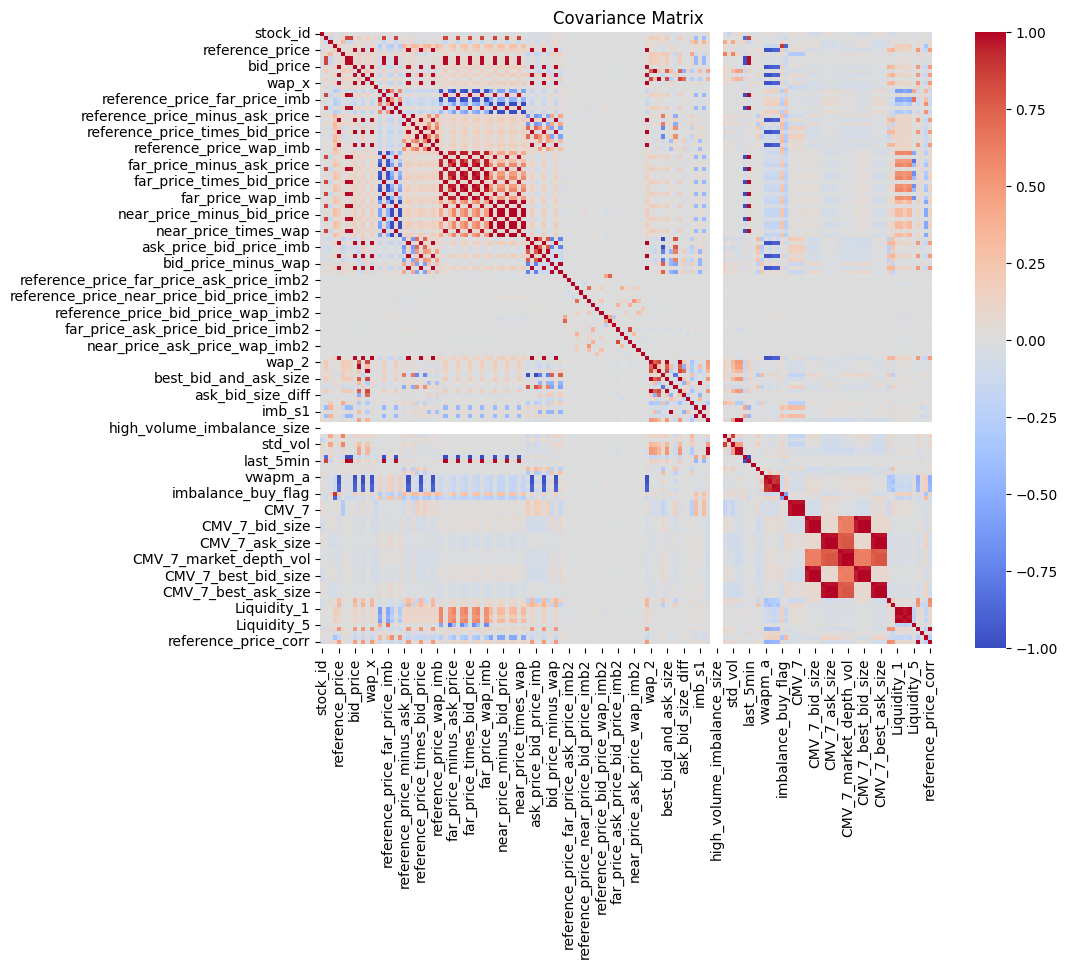

In [155]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Covariance Matrix')
plt.show()

**进行简单的相关性裁剪，将相关系数大于0.9的特征对删除其中一个**

In [156]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(1e-6)
factor_cols = X_train.columns.tolist()
Xtr = vt.fit_transform(X_train)
feat1 = np.array(factor_cols)[vt.get_support()]
v = X_train.var(axis=0)
print((v < 1e-6).sum(), len(v))
# 简易相关性裁剪
C = np.corrcoef(Xtr, rowvar=False)
keep, drop = [], set()
for i in range(C.shape[0]):
    if i in drop: continue
    keep.append(i)
    drop.update(j for j in range(i+1, C.shape[0]) if abs(C[i,j])>=0.9)

feat_keep = feat1[keep]
print(len(factor_cols))
print(len(feat_keep))
X_train_cut = X_train[feat_keep]

27 150
150
55


In [157]:
corr_matrix_cut = X_train_cut.corr()

**裁切后的特征协方差**

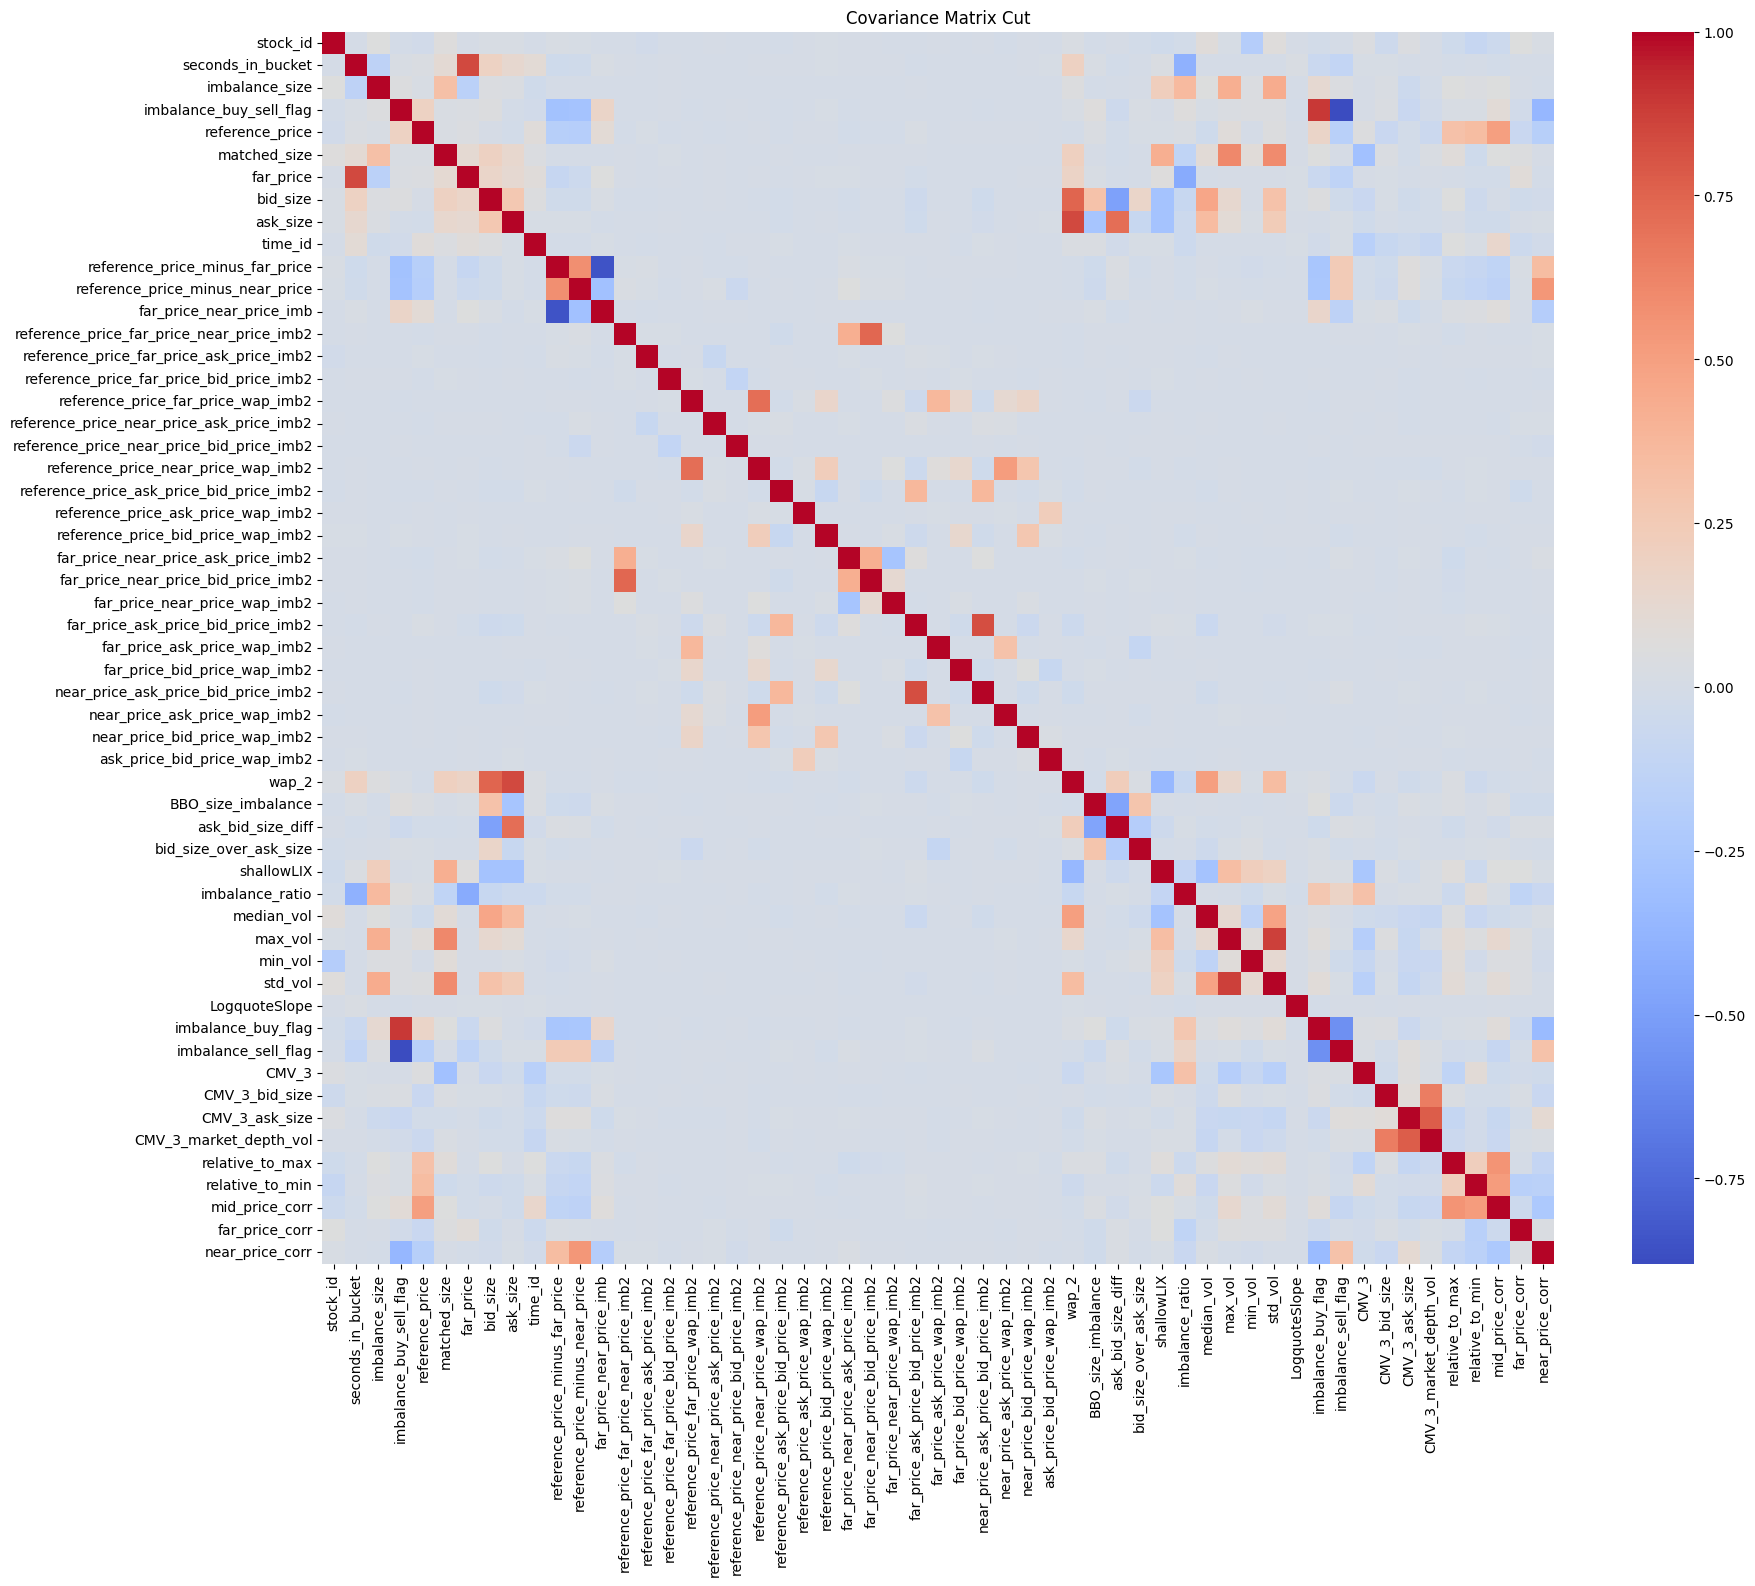

In [158]:
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix_cut, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Covariance Matrix Cut')
plt.show()

In [159]:
estimator = lightgbm.LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample_for_bin=200000, 
    objective='mae', 
    class_weight=None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=SEED, 
    n_jobs=-1, 
    importance_type='gain',#split
    force_row_wise=True
)

In [160]:
n_splits = 5
n_repeats = 10

In [216]:
def run_permutation_rerank_analysis(
        X_train, 
        y_train,
        estimator,
        n_splits=5,
        n_repeats=1,
        random_state=42,
        top_n_features=10
    ):
    """
    将 permutation 重排的重要性计算、稳定性分析、所有可视化图表
    封装到一个函数里输出。
    
    返回:
        ranking_comparison : DataFrame
        stability_summary  : DataFrame
    """

    import numpy as np
    import pandas as pd
    import sklearn as sk
    import matplotlib.pyplot as plt
    from sklearn.inspection import permutation_importance

    # ----------------------------------------------
    # 1) K 折 permutation importance 计算
    # ----------------------------------------------
    feature_importance_permuation_list = []
    feature_importance_permuation_std_list = []
    splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train, y_train)

    for fold, (train_idx, val_idx) in enumerate(splitter):
        model = sk.base.clone(estimator)

        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold   = X_train.iloc[val_idx]
        y_val_fold   = y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)

        result = permutation_importance(
            model,
            X_val_fold,
            y_val_fold,
            scoring='neg_mean_absolute_error',
            n_repeats=n_repeats,
            random_state=random_state
        )

        imp_mean = pd.Series(result.importances_mean, index=X_train.columns)
        imp_std  = pd.Series(result.importances_std, index=X_train.columns)

        feature_importance_permuation_list.append(imp_mean)
        feature_importance_permuation_std_list.append(imp_std)

    # ----------------------------------------------
    # 2) 汇总重要性 & 稳定性指标
    # ----------------------------------------------
    permutation_importance_by_fold = pd.concat(feature_importance_permuation_list, axis=1)
    permutation_importance_by_fold.columns = [f'fold_{i}' for i in range(n_splits)]

    permutation_importance_std_by_fold = pd.concat(feature_importance_permuation_std_list, axis=1)
    permutation_importance_std_by_fold.columns = [f'fold_{i}_std' for i in range(n_splits)]

    permutation_importance_mean = permutation_importance_by_fold.mean(axis=1)
    permutation_importance_fold_std = permutation_importance_by_fold.std(axis=1)
    permutation_importance_fold_cv  = (
        permutation_importance_fold_std / (np.abs(permutation_importance_mean) + 1e-8)
    )
    permutation_importance_by_fold['avg_fold'] = permutation_importance_mean
    stability_summary = pd.DataFrame({
        'permutation_importance_mean': permutation_importance_mean,
        'permutation_importance_fold_std': permutation_importance_fold_std,
        'permutation_importance_fold_cv': permutation_importance_fold_cv
    }).sort_values('permutation_importance_mean', ascending=False)

    # ----------------------------------------------
    # 3) 可视化图表打包输出
    # ----------------------------------------------
    # ==================== 可视化 1：各折重要性热力图 ====================
    plt.figure(figsize=(14, 8))
    sns.heatmap(permutation_importance_by_fold.sort_values('avg_fold', ascending=False).iloc[:20],
                annot=True, fmt='.4f', cmap='RdYlGn', cbar_kws={'label': 'Importance'})
    plt.title('Top 20 Features: Permutation Importance across Folds')
    plt.ylabel('Feature')
    plt.xlabel('Fold')
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------
    # 4) ranking_comparison （特征排序表）
    # ----------------------------------------------
    ranking_comparison = pd.DataFrame({
        'Feature': stability_summary.index,
        'Mean_Importance': stability_summary['permutation_importance_mean'],
        'CV': stability_summary['permutation_importance_fold_cv']
    })

    return ranking_comparison, stability_summary,permutation_importance_by_fold


**对原本没有进行相关性裁剪的数据进行permutation**

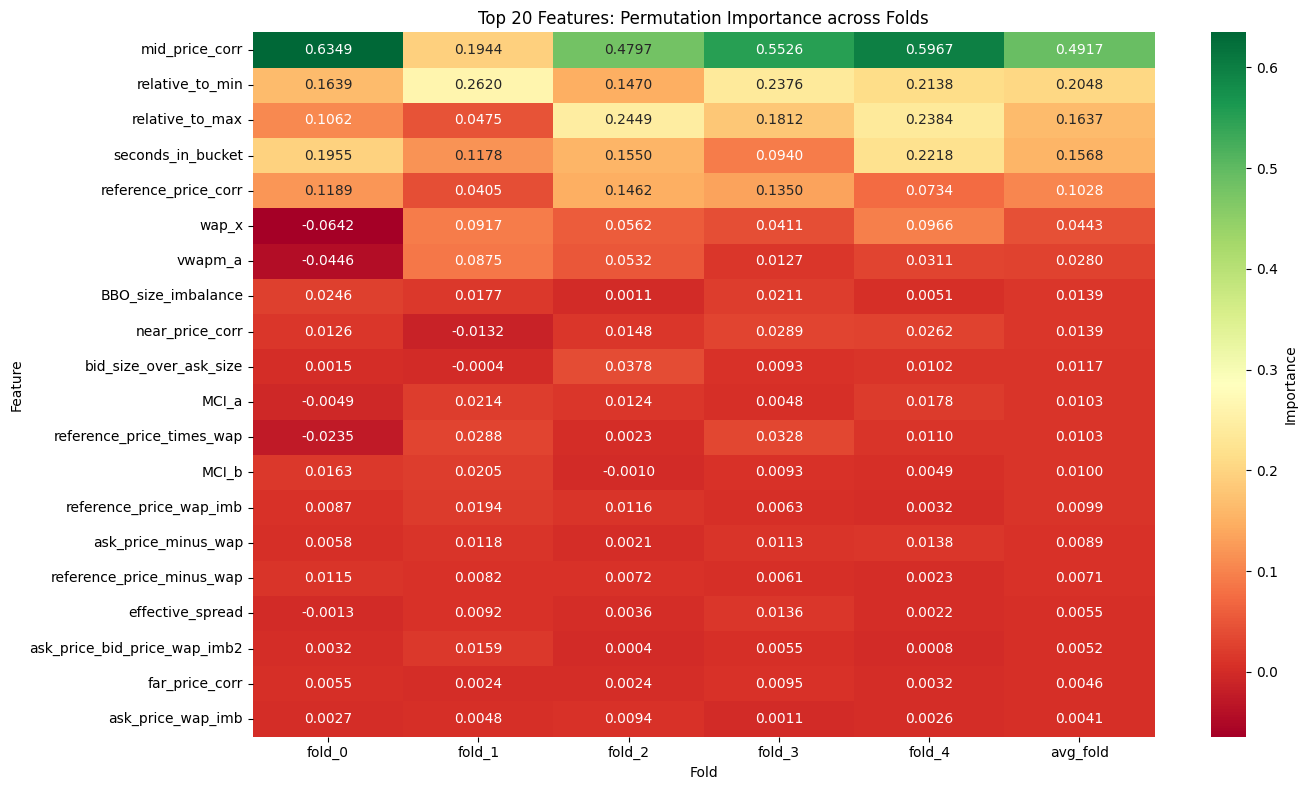

In [217]:
ranking_comparison_raw, stability_summary_raw,importance_raw = run_permutation_rerank_analysis(
    X_train,
    y_train,
    estimator=estimator,    
    n_splits=5,
    n_repeats=10
)

**对裁剪后的数据进行permutation**

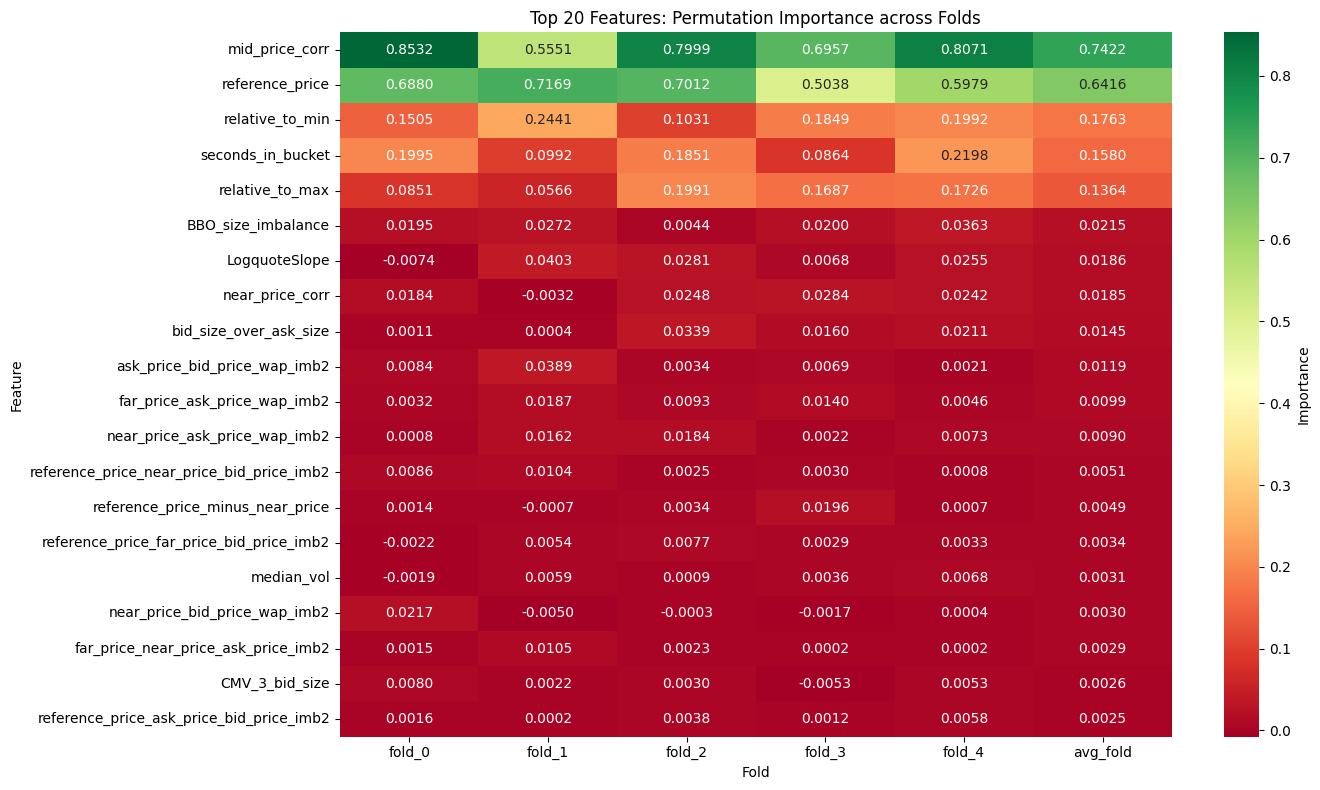

In [218]:
ranking_comparison_clip, stability_summary_clip,importance_clip = run_permutation_rerank_analysis(
    X_train_cut,
    y_train,
    estimator=estimator,    
    n_splits=5,
    n_repeats=10
)

## 方法二：分组permutation

将相关性高的特征分为一组，统一打乱，统一计算permutation

In [219]:
def run_permutation_rerank_analysis_grouped2(
        X_train, 
        y_train,
        estimator,
        n_splits=5,
        n_repeats=5,
        random_state=42,
        top_n_features=10,
        group_by_corr=True,
        corr_threshold=0.9
    ):
    """
    针对多重共线性做了“成组 permutation”的版本：
    - 先按相关性把特征分组（高于 corr_threshold 的特征归为一组）；
    - permutation 时按“组”为单位一起打乱；
    - importance 在 group 维度上汇总（组名 = 组中第一个特征名）；
    - 输出时保留特征层和组层的分组信息。

    返回:
        ranking_comparison      : 代表特征的排序表（每组选一个代表）
        stability_summary       : 特征层面的稳定性 + 分组信息
        group_stability_summary : 组层面的稳定性汇总（index = group_name）
        group_membership        : 每个特征属于哪个组、是否为代表特征
    """

    import numpy as np
    import pandas as pd
    import sklearn as sk
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_absolute_error

    rng = np.random.RandomState(random_state)

    # ----------------------------------------------
    # 0) 按相关性构造“特征组”（用于 group permutation）
    # ----------------------------------------------
    feature_names = list(X_train.columns)

    if group_by_corr:
        # 只对数值列做相关性分组
        num_cols = X_train.select_dtypes(include=[np.number]).columns
        corr = X_train[num_cols].corr().abs()

        used = set()
        groups = []

        for col in corr.columns:
            if col in used:
                continue

            # 与当前特征相关系数 >= 阈值 的特征归为一组
            group_cols = list(corr.columns[corr[col] >= corr_threshold])

            # 防止出现空组：如果为空，直接跳过，让它后面走 leftover 单独成组
            if len(group_cols) == 0:
                continue

            groups.append(group_cols)
            used.update(group_cols)

        # 对于没有出现在任何 group 里的特征，逐个补成“单特征组”
        leftover = [f for f in feature_names if f not in used]
        for f in leftover:
            groups.append([f])

        # 再保险：彻底去掉可能残留的空组
        groups = [g for g in groups if len(g) > 0]

    else:
        groups = [[f] for f in feature_names]

    # 组名 = 组中第一个特征的名字
    group_names = [g[0] for g in groups]

    # feature -> group_name 映射
    feature_to_group_name = {}
    for g_name, g in zip(group_names, groups):
        for f in g:
            feature_to_group_name[f] = g_name

    # ----------------------------------------------
    # 1) K 折 group-permutation importance 计算
    # ----------------------------------------------
    feature_importance_permuation_list = []
    feature_importance_permuation_std_list = []

    splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train, y_train)

    for fold, (train_idx, val_idx) in enumerate(splitter):
        model = sk.base.clone(estimator)

        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold   = X_train.iloc[val_idx]
        y_val_fold   = y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)

        # baseline score（这里沿用 neg MAE 的逻辑）
        y_pred_base = model.predict(X_val_fold)
        base_score = -mean_absolute_error(y_val_fold, y_pred_base)

        # 存每个特征在当前 fold 的 importance（组内特征先共用组分数）
        imp_mean = pd.Series(0.0, index=feature_names)
        imp_std  = pd.Series(0.0, index=feature_names)

        # 遍历每一组，做“成组打乱”
        for group in groups:
            scores = []
            for _ in range(n_repeats):
                X_perm = X_val_fold.copy()
                # 这一组的所有特征一起打乱
                for col in group:
                    X_perm[col] = rng.permutation(X_perm[col].values)

                y_pred_perm = model.predict(X_perm)
                perm_score = -mean_absolute_error(y_val_fold, y_pred_perm)
                # importance = baseline - permuted（越大越重要）
                scores.append(base_score - perm_score)

            group_imp_mean = np.mean(scores)
            group_imp_std  = np.std(scores)

            # 组内特征全部赋同一分数（后面会在 group 维度上再整合）
            for col in group:
                imp_mean[col] = group_imp_mean
                imp_std[col]  = group_imp_std

        feature_importance_permuation_list.append(imp_mean)
        feature_importance_permuation_std_list.append(imp_std)

    # ----------------------------------------------
    # 2) 汇总重要性 & 稳定性指标（特征层）
    # ----------------------------------------------
    permutation_importance_by_fold = pd.concat(feature_importance_permuation_list, axis=1)
    permutation_importance_by_fold.columns = [f'fold_{i}' for i in range(n_splits)]

    permutation_importance_std_by_fold = pd.concat(feature_importance_permuation_std_list, axis=1)
    permutation_importance_std_by_fold.columns = [f'fold_{i}_std' for i in range(n_splits)]

    permutation_importance_mean = permutation_importance_by_fold.mean(axis=1)
    permutation_importance_fold_std = permutation_importance_by_fold.std(axis=1)
    permutation_importance_fold_cv  = (
        permutation_importance_fold_std / (np.abs(permutation_importance_mean) + 1e-8)
    )

    permutation_importance_by_fold['avg_fold'] = permutation_importance_mean

    # 特征层的稳定性汇总 + 组名
    stability_summary = pd.DataFrame({
        'permutation_importance_mean': permutation_importance_mean,
        'permutation_importance_fold_std': permutation_importance_fold_std,
        'permutation_importance_fold_cv': permutation_importance_fold_cv,
        'group_name': [feature_to_group_name[f] for f in permutation_importance_mean.index]
    }).sort_values('permutation_importance_mean', ascending=False)

    # ---------- 新增：按 group_name 汇总 group-level importance ----------
    feature_group_index = pd.Series(
        [feature_to_group_name[f] for f in permutation_importance_by_fold.index],
        index=permutation_importance_by_fold.index,
        name="group_name",
    )

    cols_fold = [c for c in permutation_importance_by_fold.columns if c.startswith("fold_")]
    group_importance_by_fold = (
        permutation_importance_by_fold[cols_fold]
        .groupby(feature_group_index)
        .mean()
    )

    group_importance_mean = group_importance_by_fold.mean(axis=1)
    group_importance_std  = group_importance_by_fold.std(axis=1)
    group_importance_cv   = group_importance_std / (np.abs(group_importance_mean) + 1e-8)

    group_importance_by_fold["avg_fold"] = group_importance_mean

    group_stability_summary = pd.DataFrame({
        "group_importance_mean": group_importance_mean,
        "group_importance_fold_std": group_importance_std,
        "group_importance_fold_cv": group_importance_cv,
    }).sort_values("group_importance_mean", ascending=False)

    # ----------------------------------------------
    # 3) 可视化图表（这里仍按特征画；你也可以改成按 group_name 画）
    # ----------------------------------------------
        # 图 1：各折重要性热力图
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        group_importance_by_fold.sort_values('avg_fold', ascending=False).iloc[:20],
        annot=True, fmt='.4f', cmap='RdYlGn', cbar_kws={'label': 'Importance'}
    )
    plt.title('Top 20 Features: Group-Permutation Importance across Folds')
    plt.ylabel('Feature')
    plt.xlabel('Fold')
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------
    # 4) ranking_comparison：按 group 排序，选代表特征
    # ----------------------------------------------
    # 选 importance 最大的前 top_n_features 个“组”
    top_groups = group_stability_summary.head(top_n_features).index.tolist()

    # 每个组挑一个代表特征（该组中 importance 最大的那个）
    rep_features = (
        stability_summary
        .reset_index()
        .rename(columns={"index": "Feature"})
        .loc[lambda df: df["group_name"].isin(top_groups)]
        .sort_values(["group_name", "permutation_importance_mean"], ascending=[True, False])
        .groupby("group_name")
        .head(1)
    )

    ranking_comparison = rep_features[[
        "Feature",
        "permutation_importance_mean",
        "permutation_importance_fold_cv",
        "group_name",
    ]].rename(columns={
        "permutation_importance_mean": "Mean_Importance",
        "permutation_importance_fold_cv": "CV",
    }).sort_values("Mean_Importance", ascending=False)

    # ----------------------------------------------
    # 5) 分组信息：每个特征属于哪个组、是否是代表特征
    # ----------------------------------------------
    group_membership = (
        stability_summary
        .reset_index()
        .rename(columns={"index": "Feature"})
        [["Feature", "group_name"]]
    )

    rep_flag = rep_features[["Feature", "group_name"]].copy()
    rep_flag["is_group_rep"] = True

    group_membership = group_membership.merge(
        rep_flag, on=["Feature", "group_name"], how="left"
    )
    group_membership["is_group_rep"] = group_membership["is_group_rep"].fillna(False)

    # 排序方便看：先按 group_name，再按代表优先
    group_membership = group_membership.sort_values(
        ["group_name", "is_group_rep", "Feature"],
        ascending=[True, False, True]
    )

    return ranking_comparison, stability_summary, group_stability_summary, group_membership,group_importance_by_fold


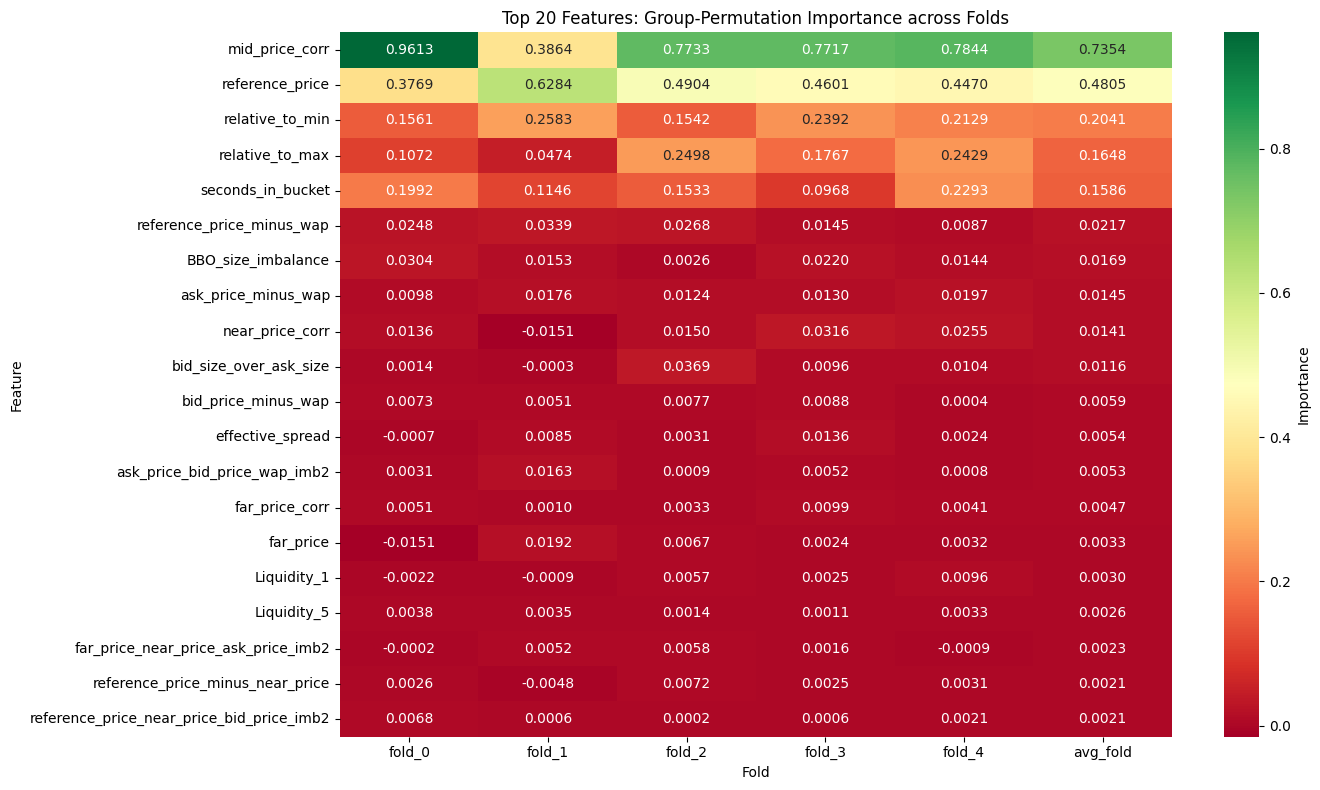

C:\Users\lenovo\AppData\Local\Temp\ipykernel_27940\1748463668.py:242: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_membership["is_group_rep"] = group_membership["is_group_rep"].fillna(False)


In [220]:
ranking_comparison_grp, stability_summary_grp, group_stability_summary_grp, group_membership_grp,importance_grp = run_permutation_rerank_analysis_grouped2(
    X_train,
    y_train,
    estimator=estimator,     
    n_splits=5,
    n_repeats=10
)

**三种permutation的结果**

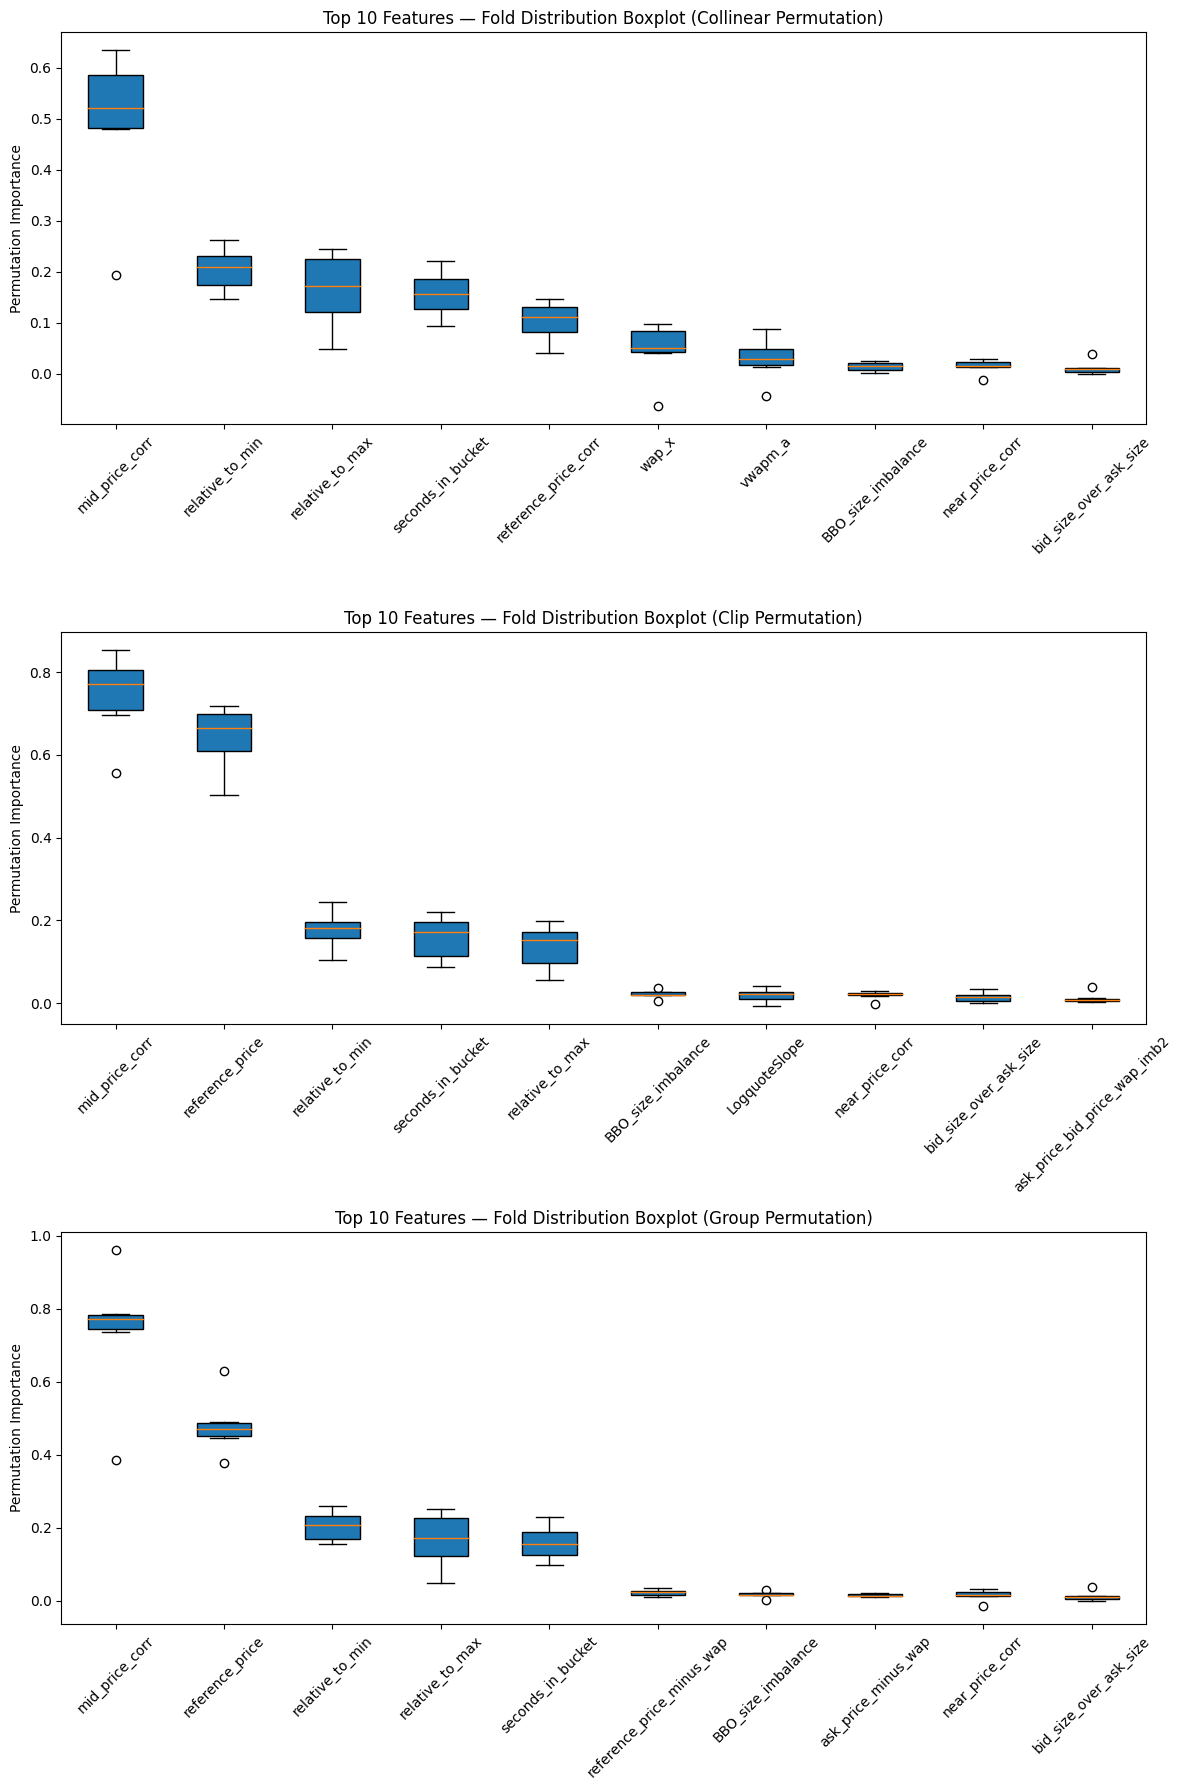

In [221]:
fig, ax = plt.subplots(3,1,figsize=(12, 18))
selected_raw = stability_summary_raw.head(10).index
box_data_raw = [importance_raw.loc[f].values for f in selected_raw]
ax[0].boxplot(box_data_raw, labels=selected_raw, patch_artist=True)
ax[0].set_title(f'Top 10 Features — Fold Distribution Boxplot (Collinear Permutation)')
ax[0].set_ylabel('Permutation Importance')

selected_clip = stability_summary_clip.head(10).index
box_data_clip = [importance_clip.loc[f].values for f in selected_clip]
ax[1].boxplot(box_data_clip, labels=selected_clip, patch_artist=True)
ax[1].set_title(f'Top 10 Features — Fold Distribution Boxplot (Clip Permutation)')
ax[1].set_ylabel('Permutation Importance')

selected_grp = group_stability_summary_grp.head(10).index
box_data = [importance_grp.loc[f].values for f in selected_grp]
ax[2].boxplot(box_data, labels=selected_grp, patch_artist=True)
ax[2].set_title(f'Top 10 Features — Fold Distribution Boxplot (Group Permutation)')
ax[2].set_ylabel('Permutation Importance')
# plt.xticks(rotation=45)
for axis in ax:
    axis.tick_params(axis='x', rotation=45)

# 增加子图之间的垂直间距
plt.subplots_adjust(hspace=0.5)  # 调整这个值来控制间距大小
plt.tight_layout()
plt.show()

## permutaion结果

-可以看到使用相关性裁切和分组permutaion的方法得到的top10特征和对应的重要性基本相同

-而包含多重共线性的原始数据在使用permutation时会明显低估`reference_price`系列因子的重要性